<h1> Basic Machine Learning Approach to housing prices in King County, WA </h1>

In this notebook we will show a basic approach to create some Machine Learning models to predict the housing prices in King County. This is a public dataset found in Kaggle, related to the prices of houses based on variables like number of bathrooms, bedrooms, area, view, condition, etc.

This code is mainly used to show some possible approaches to Regression models and is not focused on specific analysis of the dataset or outcome. To compare the different models we will use RMSE.

In [1]:
#Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm
from pygam import LinearGAM, s, f

In [2]:
#Import data
data_raw = pd.read_csv(os.getcwd() + '/TrainReg.csv', sep = ';')
data_raw.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,1380000.0,5,3.50,3680,8680,2.0,0,0,3,9,3680,0,2003,0,476.575,-122.197,2020,8847
1,550000.0,3,2.50,1550,1092,3.0,0,0,3,8,1390,160,2004,0,476.355,-122.324,1550,1079
2,620000.0,3,1.00,1710,4050,1.5,0,0,3,7,1710,0,1909,0,476.732,-122.331,1790,4896
3,509000.0,4,2.00,1630,1724,1.5,0,0,3,6,1030,600,1915,1970,476.472,-122.362,1780,3810
4,405000.0,3,2.25,1590,7267,1.0,0,0,4,7,1100,490,1976,0,477.457,-122.332,2060,8336


As we see, we have a lot of variables, so we can reorder columns for easier management. The first columns will have the description of the house attributes, next will be the columns related to area and then the ones related to categorical attributes. At the end we'll add the coordinates.

In [3]:
data_o = data_raw[['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                  'sqft_living15', 'sqft_lot15', 'view', 'condition', 'grade', 'waterfront', 'yr_built', 'yr_renovated', 
                  'lat', 'long']]
data_o.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,condition,grade,waterfront,yr_built,yr_renovated,lat,long
0,1380000.0,5,3.50,2.0,3680,8680,3680,0,2020,8847,0,3,9,0,2003,0,476.575,-122.197
1,550000.0,3,2.50,3.0,1550,1092,1390,160,1550,1079,0,3,8,0,2004,0,476.355,-122.324
2,620000.0,3,1.00,1.5,1710,4050,1710,0,1790,4896,0,3,7,0,1909,0,476.732,-122.331
3,509000.0,4,2.00,1.5,1630,1724,1030,600,1780,3810,0,3,6,0,1915,1970,476.472,-122.362
4,405000.0,3,2.25,1.0,1590,7267,1100,490,2060,8336,0,4,7,0,1976,0,477.457,-122.332


Now we use the describe and info functions to check the distribution and general behaviour of the data

In [4]:
data_o.describe()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,condition,grade,waterfront,yr_built,yr_renovated,lat,long
count,1.899900e+04,18999.000000,18999.000000,18999.000000,18999.000000,1.899900e+04,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000
mean,5.395405e+05,3.367914,2.114138,1.495316,2078.104005,1.513203e+04,1788.395442,289.708564,1987.436602,12673.042160,0.234749,3.408758,7.655771,0.007527,1971.093426,85.710248,430.647794,-122.213538
std,3.675456e+05,0.935781,0.771100,0.540208,913.927486,4.156565e+04,826.298024,440.576116,685.275633,25916.445655,0.767504,0.649795,1.175260,0.086432,29.321687,404.618575,131.227910,0.140516
min,7.800000e+04,0.000000,0.000000,1.000000,290.000000,5.200000e+02,290.000000,0.000000,460.000000,659.000000,0.000000,1.000000,1.000000,0.000000,1900.000000,0.000000,47.184000,-122.519000
25%,3.200000e+05,3.000000,1.500000,1.000000,1420.000000,5.054000e+03,1190.000000,0.000000,1490.000000,5100.000000,0.000000,3.000000,7.000000,0.000000,1952.000000,0.000000,473.833000,-122.328000
50%,4.500000e+05,3.000000,2.250000,1.500000,1910.000000,7.620000e+03,1560.000000,0.000000,1840.000000,7622.000000,0.000000,3.000000,7.000000,0.000000,1975.000000,0.000000,475.521000,-122.229000
75%,6.450000e+05,4.000000,2.500000,2.000000,2550.000000,1.069600e+04,2210.000000,560.000000,2370.000000,10086.500000,0.000000,4.000000,8.000000,0.000000,1997.000000,0.000000,476.692000,-122.124000
max,7.700000e+06,33.000000,8.000000,3.500000,12050.000000,1.651359e+06,8860.000000,4820.000000,6110.000000,560617.000000,4.000000,5.000000,13.000000,1.000000,2015.000000,2015.000000,477.776000,-121.315000


In [5]:
data_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18999 entries, 0 to 18998
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          18999 non-null  float64
 1   bedrooms       18999 non-null  int64  
 2   bathrooms      18999 non-null  float64
 3   floors         18999 non-null  float64
 4   sqft_living    18999 non-null  int64  
 5   sqft_lot       18999 non-null  int64  
 6   sqft_above     18999 non-null  int64  
 7   sqft_basement  18999 non-null  int64  
 8   sqft_living15  18999 non-null  int64  
 9   sqft_lot15     18999 non-null  int64  
 10  view           18999 non-null  int64  
 11  condition      18999 non-null  int64  
 12  grade          18999 non-null  int64  
 13  waterfront     18999 non-null  int64  
 14  yr_built       18999 non-null  int64  
 15  yr_renovated   18999 non-null  int64  
 16  lat            18999 non-null  float64
 17  long           18999 non-null  float64
dtypes: flo

We can see that there are almost 19000 observations in this dataset. Also we can see that there are houses with 0 bedrooms and  bathrooms, which doesn't really sound right, although, given we don't have enough documentation, we will assume this can be possible as some sort of studio or office situation.

Even if the variation in latitude and longitude is way too low, we won't drop this features yet, but we won't be developing any geostatistical analysis this time.

We build some histograms to check the general distribution of some variables that can be both considered contiunous and categorical like bedrooms and bathrooms.

Text(0.5, 1.0, 'Waterfront')

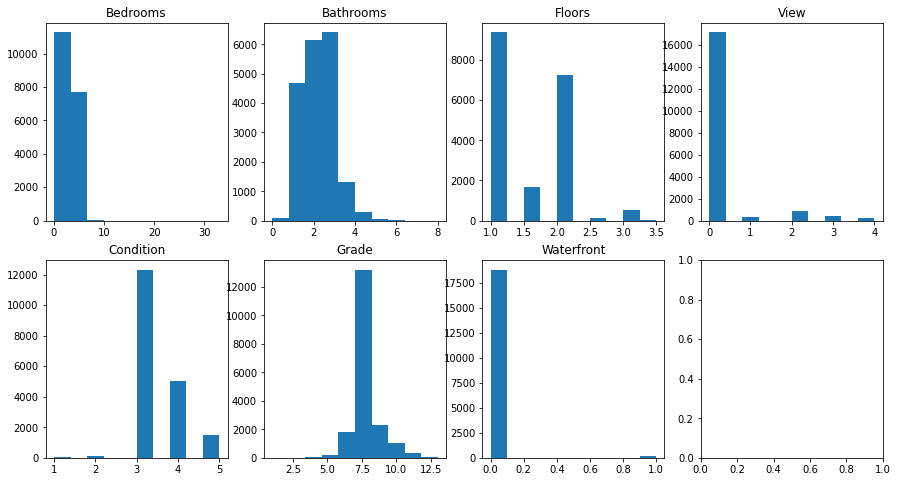

In [6]:
#Plotting ambiguous features
fig, ax = plt.subplots(2, 4, figsize = (15,8))
ax[0,0].hist(x = 'bedrooms', data = data_o)
ax[0,0].set_title('Bedrooms')
ax[0,1].hist(x = 'bathrooms', data = data_o)
ax[0,1].set_title('Bathrooms')
ax[0,2].hist(x = 'floors', data = data_o)
ax[0,2].set_title('Floors')
ax[0,3].hist(x = 'view', data = data_o)
ax[0,3].set_title('View')
ax[1,0].hist(x = 'condition', data = data_o)
ax[1,0].set_title('Condition')
ax[1,1].hist(x = 'grade', data = data_o)
ax[1,1].set_title('Grade')
ax[1,2].hist(x = 'waterfront', data = data_o)
ax[1,2].set_title('Waterfront')

As we can see, most houses have less than 5 bedrooms, and 4 bathrooms. Also, Most houses don't have a waterfront and their view is graded as 0. On the Condition and Grade, most houses have an average condition of 3/5 and good Grades. Given this approach we will considere bedrooms, bathrooms and floors to be continuous variables, and the other ones presented will be categorical.

As a lot of houses are not renovated, we can use this variable as categorical, so, when it will get a value of 1 if the house was renovated and 0 otherwise.

In [7]:
data_o['yr_renovated'].loc[(data_o['yr_renovated']>0)] = 1
data_o.head()

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,condition,grade,waterfront,yr_built,yr_renovated,lat,long
0,1380000.0,5,3.50,2.0,3680,8680,3680,0,2020,8847,0,3,9,0,2003,0,476.575,-122.197
1,550000.0,3,2.50,3.0,1550,1092,1390,160,1550,1079,0,3,8,0,2004,0,476.355,-122.324
2,620000.0,3,1.00,1.5,1710,4050,1710,0,1790,4896,0,3,7,0,1909,0,476.732,-122.331
3,509000.0,4,2.00,1.5,1630,1724,1030,600,1780,3810,0,3,6,0,1915,1,476.472,-122.362
4,405000.0,3,2.25,1.0,1590,7267,1100,490,2060,8336,0,4,7,0,1976,0,477.457,-122.332


<h2> Correlation </h2>

With this dataframe we can now check for correlation

<AxesSubplot:>

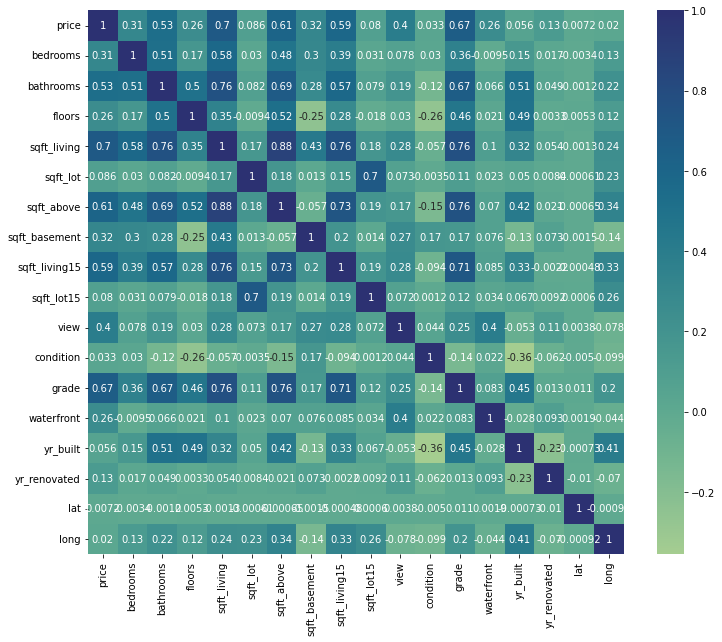

In [8]:
plt.figure(figsize = (12,10))
sns.heatmap(data_o.corr(), annot = True, cmap='crest')

We can see big correlation between grade, bathrooms, sqft_living and sqft_living15. We can consider later to drop some of this features to avoid overfitting in the models.

We will create a pairplot with the continuous variables, so we can check the relationship of each with the price.

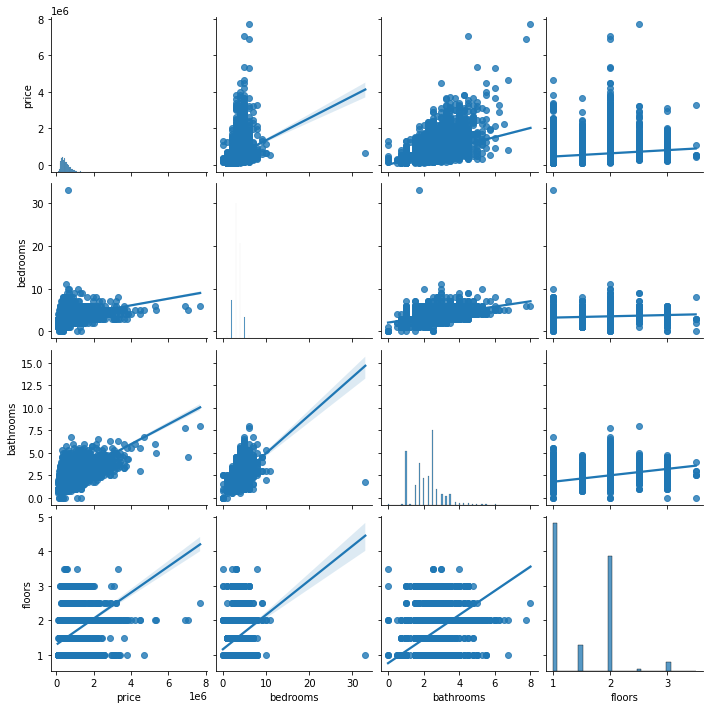

In [9]:
sns.pairplot(data_o,vars = ['price','bedrooms','bathrooms','floors'], kind = 'reg')

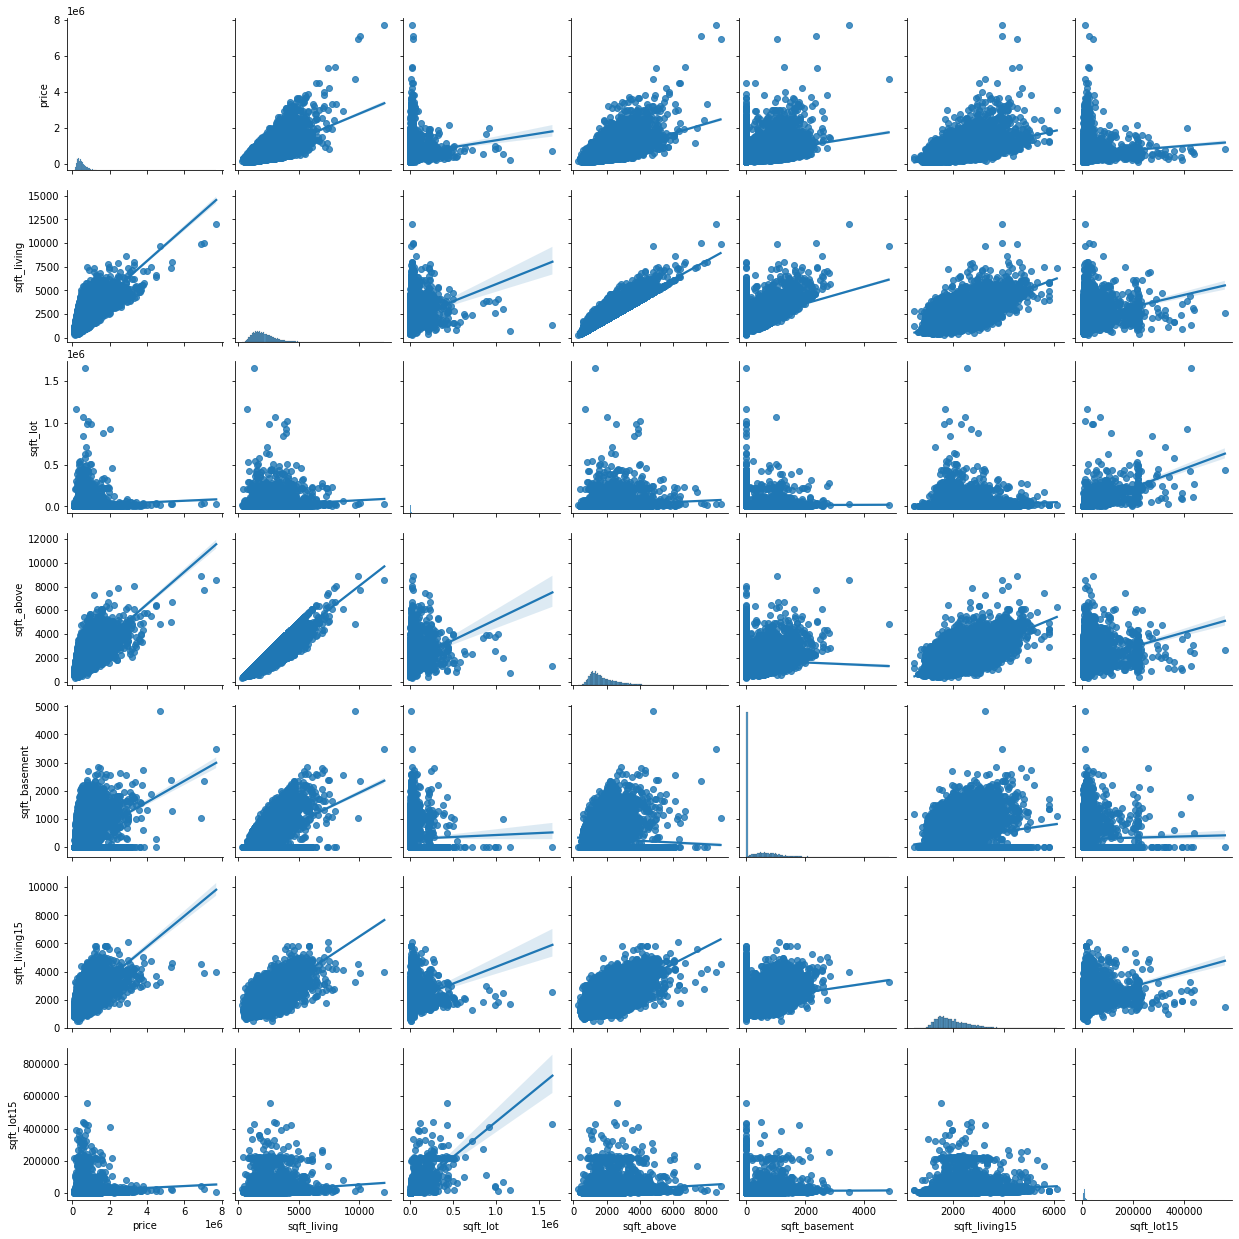

In [10]:
sns.pairplot(data_o,vars =  ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], kind = 'reg')

<h2> Data preprocessing </h2>

We now scale and center the continuous variables, so we can use all of our models without restrictions. The Min-Max scaler is used for this.

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()

#scaled dataframe
data_s = data_o.copy()
data_s['bedrooms'] = min_max_scaler.fit_transform(data_s['bedrooms'].values.reshape(-1,1))
data_s['bathrooms'] = min_max_scaler.fit_transform(data_s['bathrooms'].values.reshape(-1,1))
data_s['floors'] = min_max_scaler.fit_transform(data_s['floors'].values.reshape(-1,1))
data_s['sqft_living'] = min_max_scaler.fit_transform(data_s['sqft_living'].values.reshape(-1,1))
data_s['sqft_lot'] = min_max_scaler.fit_transform(data_s['sqft_lot'].values.reshape(-1,1))
data_s['sqft_basement'] = min_max_scaler.fit_transform(data_s['sqft_basement'].values.reshape(-1,1))
data_s['sqft_above'] = min_max_scaler.fit_transform(data_s['sqft_above'].values.reshape(-1,1))
data_s['sqft_living15'] = min_max_scaler.fit_transform(data_s['sqft_living15'].values.reshape(-1,1))
data_s['sqft_lot15'] = min_max_scaler.fit_transform(data_s['sqft_lot15'].values.reshape(-1,1))
data_s['yr_built'] = min_max_scaler.fit_transform(data_s['yr_built'].values.reshape(-1,1))
data_s['lat'] = min_max_scaler.fit_transform(data_s['lat'].values.reshape(-1,1))
data_s['long'] = min_max_scaler.fit_transform(data_s['long'].values.reshape(-1,1))

data_s.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,condition,grade,waterfront,yr_built,yr_renovated,lat,long
0,1380000.0,0.151515,0.43750,0.4,0.288265,0.004943,0.395566,0.000000,0.276106,0.014623,0,3,9,0,0.895652,0,0.997211,0.267442
1,550000.0,0.090909,0.31250,0.8,0.107143,0.000346,0.128355,0.033195,0.192920,0.000750,0,3,8,0,0.904348,0,0.996700,0.161960
2,620000.0,0.090909,0.12500,0.2,0.120748,0.002138,0.165694,0.000000,0.235398,0.007567,0,3,7,0,0.078261,0,0.997575,0.156146
3,509000.0,0.121212,0.25000,0.2,0.113946,0.000729,0.086348,0.124481,0.233628,0.005627,0,3,6,0,0.130435,1,0.996972,0.130399
4,405000.0,0.090909,0.28125,0.0,0.110544,0.004087,0.094516,0.101660,0.283186,0.013710,0,4,7,0,0.660870,0,0.999259,0.155316


Now we make a random split of the data to create a a sample for training and anotherone for testing

In [12]:
X = data_s.drop('price', axis = 1)
y = data_s['price']
X_train, X_test,y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)

We will now create some models to fit the data and try to create the best prediction. The comparisson between the models will be based on RMSE.

<h2> Linear regression </h2>

We'll create a linear model with the OLS method, just as a base for the future prediction methods.

In [13]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

We create a prediction with the X_test set and then compare it with the y_test, to get a Root Mean Squared Error, so we can compare this model with others

In [14]:
y_test_hat = lm.predict(X_test)

In [15]:
rmse_lm = np.sqrt(metrics.mean_squared_error(y_test, y_test_hat))
print(f'RMSE Linear Regression = {rmse_lm}')

RMSE Linear Regression = 227412.5259969978


In [16]:
print(f'R2 = {metrics.r2_score(y_test, y_test_hat)}')

R2 = 0.6492346427725844


The R2 score shows that this dataset doesn't particularly follow a linear model. This means the relationship between all the variables and the price is more complex that a simple straight line.

We assume that the RMSE obtained can be lowered with models better fitted for prediction. We will now compare this to a GAM model, ElasticNet, and some Regression Trees.

<h2> Elasticnet </h2>

We create a model with penalizations using ElasticNet

In [17]:
elasticNet = ElasticNetCV(
            l1_ratio= [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas = np.linspace(0.01, 1, 100),
            cv = 10
         )
elasticNet.fit(X_train, y_train)

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 545947473230907.6, tolerance: 156645579129.48383
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390692872688232.94, tolerance: 156645579129.48383
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451941275560225.8, tolerance: 156048130002.79672
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496818376048683.4, tolerance: 159427755102.7403
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495184646708375.6, tolerance: 159427755102.7403
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515610007216243.25, tolerance: 156083109059.32053
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535941516930914.7, tolerance: 157028437740.46368
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541053981686975.2, tolerance: 154107417224.0273
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540082317500882.0, tolerance: 154107417224.0273
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 385555386586048.7, tolerance: 154107417224.0273
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429305428984066.25, tolerance: 157939261445.55396
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431491884317838.4, tolerance: 151145107459.1016
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459254205930902.3, tolerance: 149280526918.80902
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 514869612087957.75, tolerance: 155696633948.68616
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_desc

ElasticNetCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
             cv=10, l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99])

In [18]:
y_hat_elasticnet = elasticNet.predict(X_test)

In [19]:
rmse_en = np.sqrt(metrics.mean_squared_error(y_test, y_hat_elasticnet))
print(f'RMSE ElasticNet = {rmse_en}')

RMSE ElasticNet = 227786.4998026372


We arrive to an even worst RMSE using ElasticNet. For now we won't try to improve this, instead we will build some Machine Learning Models to get a better fit

<h2> GAMS </h2>

We start by building a GAM model

In [20]:
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10) + f(12) + f(13) + s(14) + s(15) + s(16)) 
gam.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10) + f(12) + f(13) + s(14) + s(15) + s(16) + intercept,
   tol=0.0001, verbose=False)

In [21]:
y_hat_gam = gam.predict(X_test)

In [22]:
rmse_gam = np.sqrt(metrics.mean_squared_error(y_test, y_hat_gam))
print(f'RMSE ElasticNet = {rmse_gam}')

RMSE ElasticNet = 218348.16523551702


In [23]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    169.3889
Link Function:                     IdentityLink Log Likelihood:                               -335158.6921
Number of Samples:                        13299 AIC:                                            670658.162
                                                AICc:                                           670662.611
                                                GCV:                                      35972641422.4271
                                                Scale:                                    35148859338.4899
                                                Pseudo R-Squared:                                   0.7326
Feature Function                  Lam

C:\Users\JULIAN~1\AppData\Local\Temp/ipykernel_14868/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


The p-values obtained for all variables are very low, which means all of them are being significant for the model created. This might be suspisious considering the correlation between some of them.

This model clearly is giving a better fit for the given data. We use smoothing and factor approach to each feature.

<h2> Random Forest </h2>

We will now create a Random Forest model to see if using trees we can get a better fit

In [24]:
rf = RandomForestRegressor(n_estimators=500, criterion = 'squared_error', bootstrap = True, oob_score=0.8, random_state = 123)
rf.fit(X_train, y_train)

C:\Users\JULIAN OTERO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RandomForestRegressor(n_estimators=500, oob_score=0.8, random_state=123)

In [25]:
y_hat_rf = rf.predict(X_test)

In [26]:
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_hat_rf))
print(f'RMSE Random Forest = {rmse_rf}')

RMSE Random Forest = 147521.1046518432


We can see that using a random forest clearly yields a lower RMSE than using all the linear models shown before. We'll keep using trees to see if a boosting model can be better to fit the data

In [27]:
print('Feature Importance', '\n')
for num,i in enumerate(rf.feature_importances_):
    print(data_s.columns.values.tolist()[num + 1] , ' = ' , i)

Feature Importance 

bedrooms  =  0.003524531143028962
bathrooms  =  0.013558469709295914
floors  =  0.0025880220054360324
sqft_living  =  0.23734645419345138
sqft_lot  =  0.014801464676688653
sqft_above  =  0.025804707866874676
sqft_basement  =  0.008245293115597203
sqft_living15  =  0.035842745277910065
sqft_lot15  =  0.014044921900198579
view  =  0.012108986772792495
condition  =  0.003117806466523899
grade  =  0.346853003857957
waterfront  =  0.02526626209346207
yr_built  =  0.0425781999522619
yr_renovated  =  0.0015371601706131136
lat  =  0.1438062336209831
long  =  0.06897573717692507


As we can see, some variables like yr_renovated, floors and bedrooms seem to have low importance on the prediction of the price. We will later check this with a Boruta test.

<h2> Boosting </h2>

The boosting method will use the sum of sequential trees. We will use this 

In [28]:
gbt = GradientBoostingRegressor(n_estimators = 500, loss = 'squared_error',max_features = 'auto', random_state = 123)
gbt.fit(X_train, y_train)

GradientBoostingRegressor(max_features='auto', n_estimators=500,
                          random_state=123)

In [29]:
y_hat_gbt = gbt.predict(X_test)

In [30]:
rmse_gbt = np.sqrt(metrics.mean_squared_error(y_test, y_hat_gbt))
print(f'RMSE Gradient Boosting = {rmse_gbt}')

RMSE Gradient Boosting = 132924.51759772372


Using a big ammount of estimators we can get a better fit by using this boosting tree. We could improve the model by selecting only specific features using a boruta test.

In [31]:
from boruta import BorutaPy
gbt1 = GradientBoostingRegressor(n_estimators = 500, loss = 'squared_error',max_features = 'auto', random_state = 123)
feature_selected = BorutaPy(gbt1, n_estimators='auto', random_state=123)

In [32]:
feature_selected.fit(X_train.values, y_train.values)

BorutaPy(estimator=GradientBoostingRegressor(max_features='auto',
                                             n_estimators=182,
                                             random_state=RandomState(MT19937) at 0x2338F9FFD40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2338F9FFD40)

In [33]:
feature_selected.ranking_

array([3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1])

We can see the features bedrooms, floors and renovated are not that important, so we'll build a new dataframe without them and create an extra model.

In [34]:
X_train_filt = X_train[['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                  'sqft_living15', 'sqft_lot15', 'view', 'condition', 'grade', 'waterfront', 'yr_built', 
                  'lat', 'long']]
X_test_filt = X_test[['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                  'sqft_living15', 'sqft_lot15', 'view', 'condition', 'grade', 'waterfront', 'yr_built', 
                  'lat', 'long']]

In [35]:
gbt1.fit(X_train_filt, y_train)

GradientBoostingRegressor(max_features='auto', n_estimators=182,
                          random_state=RandomState(MT19937) at 0x2338F9FFD40)

In [36]:
y_hat_gbt1 = gbt1.predict(X_test_filt)

In [37]:
rmse_gbt1 = np.sqrt(metrics.mean_squared_error(y_test, y_hat_gbt1))
print(f'RMSE Gradient Boosting filtered = {rmse_gbt1}')

RMSE Gradient Boosting filtered = 138471.10037365477


As we can see, the Boruta approach not always yields better models. This might be due to the fact that this dataset is small, so this reduction of features is not so useful. 

Other approach to feature selection can be made by using the correlation between variables that was calculated earlier. This way we can drop some features that are very correlated.

We will drop the features bathrooms and sqft_living, because of the high corrrelation with grade, sqft_living15 and sqft_above.

In [38]:
X_train_filt2 = X_train[['bedrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                  'sqft_living15', 'sqft_lot15', 'view', 'condition', 'grade', 'waterfront', 'yr_built','yr_renovated', 
                  'lat', 'long']]
X_test_filt2 = X_test[['bedrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                  'sqft_living15', 'sqft_lot15', 'view', 'condition', 'grade', 'waterfront', 'yr_built','yr_renovated', 
                  'lat', 'long']]

In [39]:
gbt2 = GradientBoostingRegressor(n_estimators = 500, loss = 'squared_error',max_features = 'auto', random_state = 123)
gbt2.fit(X_train_filt2, y_train)

GradientBoostingRegressor(max_features='auto', n_estimators=500,
                          random_state=123)

In [40]:
y_hat_gbt2 = gbt2.predict(X_test_filt2)

In [41]:
rmse_gbt2 = np.sqrt(metrics.mean_squared_error(y_test, y_hat_gbt2))
print(f'RMSE Gradient Boosting filtered (corr) = {rmse_gbt2}')

RMSE Gradient Boosting filtered (corr) = 133230.05091590702


This method gives us the lowest RMSE found yet. This feature selection using correlation allows us to reduce overfitting. Thus, we get a lower error when comparing with a validation dataset.

<h2> Comparison </h2>

In [42]:
print('RMSE test', '\n')
print(f'RMSE Linear Regression = {rmse_lm}')
print(f'RMSE ElasticNet = {rmse_en}')
print(f'RMSE ElasticNet = {rmse_gam}')
print(f'RMSE Random Forest = {rmse_rf}')
print(f'RMSE Gradient Boosting = {rmse_gbt}')
print(f'RMSE Gradient Boosting filtered = {rmse_gbt1}')
print(f'RMSE Gradient Boosting filtered (corr) = {rmse_gbt2}')

RMSE test 

RMSE Linear Regression = 227412.5259969978
RMSE ElasticNet = 227786.4998026372
RMSE ElasticNet = 218348.16523551702
RMSE Random Forest = 147521.1046518432
RMSE Gradient Boosting = 132924.51759772372
RMSE Gradient Boosting filtered = 138471.10037365477
RMSE Gradient Boosting filtered (corr) = 133230.05091590702


We can see the lowest RMSE was achieved using Gradient Boosting Regression, using specific calibration for the model by removing variables with big correlation values. This shows how important it is to pay attention to the feature selection process.